# Load Datasets

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2025-10-22 01:04:17.074913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761095057.349133      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761095057.423962      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

def get_data_path(slug_name):
    base1 = f"/kaggle/input/{slug_name}"
    base2 = "/kaggle/input"
    if os.path.exists(base1):
        return base1
    elif os.path.exists(base2):
        return base2
    else:
        return "./Data"

data_dir = get_data_path("international-hotel-booking-analytics")

users = pd.read_csv(f"{data_dir}/users.csv")
hotels = pd.read_csv(f"{data_dir}/hotels.csv")
reviews = pd.read_csv(f"{data_dir}/reviews.csv")

# Data Cleaning

In [3]:
def clean_data(hotels, reviews, users):
    # merge all datasets
    tmp_df = pd.merge(hotels, reviews, on='hotel_id')
    df = pd.merge(tmp_df, users, on='user_id')
    
    # rename columns
    df.rename(columns={'country_x': 'hotel_country', 'country_y': 'user_country'}, inplace=True)

    # convert to datetime
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['join_date'] = pd.to_datetime(df['join_date'])
    
    # clean NaNs and duplicates
    df = df.drop_duplicates()
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    text_cols = df.select_dtypes(include=['object']).columns
    df[text_cols] = df[text_cols].fillna('Unknown')

    # create mapping before one-hot
    country_to_group = {
        'United States': 'North_America',
        'Canada': 'North_America',
        'Germany': 'Western_Europe',
        'France': 'Western_Europe',
        'United Kingdom': 'Western_Europe',
        'Netherlands': 'Western_Europe',
        'Spain': 'Western_Europe',
        'Italy': 'Western_Europe',
        'Russia': 'Eastern_Europe',
        'China': 'East_Asia',
        'Japan': 'East_Asia',
        'South Korea': 'East_Asia',
        'Thailand': 'Southeast_Asia',
        'Singapore': 'Southeast_Asia',
        'United Arab Emirates': 'Middle_East',
        'Turkey': 'Middle_East',
        'Egypt': 'Africa',
        'Nigeria': 'Africa',
        'South Africa': 'Africa',
        'Australia': 'Oceania',
        'New Zealand': 'Oceania',
        'Brazil': 'South_America',
        'Argentina': 'South_America',
        'India': 'South_Asia',
        'Mexico': 'North_America_Mexico'
    }

    # create the country_group column
    df['country_group'] = df['user_country'].map(country_to_group).fillna('Other')

    # binary mapping for gender
    df['user_gender'] = df['user_gender'].map({'Male': 0, 'Female': 1}).fillna(-1)
    
    # drop unnecessary columns
    df = df.drop(columns=[
        'user_id', 'hotel_id', 'review_id','join_date', 'lat', 'lon', 'user_country','hotel_name', 'review_text', 'review_date'
    ], errors='ignore')

    return df
df = clean_data(hotels, reviews, users)

In [4]:
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample data:")
df.head()

Dataset shape: (50000, 20)

Columns: ['city', 'hotel_country', 'star_rating', 'cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money', 'user_gender', 'age_group', 'traveller_type', 'country_group']

Sample data:


,city,hotel_country,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,user_gender,age_group,traveller_type,country_group
0,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,1.0,25-34,Solo,Oceania
1,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.8,8.9,8.4,8.9,8.7,8.4,1.0,55+,Solo,Western_Europe
2,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.8,8.3,8.6,9.1,9.5,9.1,7.5,0.0,25-34,Business,Oceania
3,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.8,9.3,9.4,8.2,9.1,8.3,8.4,-1.0,18-24,Couple,Western_Europe
4,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.2,8.8,8.7,9.4,9.0,7.4,1.0,35-44,Business,Africa


In [5]:
print("\nSummary statistics for numeric columns:")
display(df.describe())


Summary statistics for numeric columns:


,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,user_gender
count,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.0,9.091592,9.063918,8.917196,9.270406,9.015730,8.513232,8.943460,9.052558,9.024404,8.743062,9.176410,8.972076,8.434540,0.338960
std,0.0,0.226334,0.234129,0.286064,0.347649,0.236695,0.258259,0.180878,0.504296,0.423927,0.498320,0.421086,0.397775,0.529321,0.642273
min,5.0,8.700000,8.600000,8.500000,8.500000,8.600000,7.900000,8.200000,7.700000,7.900000,7.600000,7.900000,7.900000,6.800000,-1.000000
25%,5.0,8.900000,8.900000,8.700000,9.000000,8.800000,8.400000,8.800000,8.700000,8.700000,8.400000,8.900000,8.700000,8.100000,0.000000
50%,5.0,9.100000,9.100000,8.900000,9.300000,9.000000,8.500000,8.900000,9.100000,9.000000,8.700000,9.200000,9.000000,8.500000,0.000000
75%,5.0,9.300000,9.200000,9.100000,9.600000,9.200000,8.700000,9.100000,9.400000,9.300000,9.100000,9.500000,9.200000,8.800000,1.000000
max,5.0,9.600000,9.500000,9.600000,9.800000,9.500000,8.900000,9.600000,10.000000,10.000000,10.000000,10.000000,10.000000,9.700000,1.000000


In [6]:
print("\nValue counts for categorical columns:")
categorical_cols = ['age_group', 'traveller_type', 'user_gender', 'city', 'hotel_country', 'country_group']
for col in categorical_cols:
    print(f"\n{col} distribution:")
    print(df[col].value_counts())


Value counts for categorical columns:

age_group distribution:
age_group
25-34    16322
35-44    15452
45-54     7824
18-24     5415
55+       4987
Name: count, dtype: int64

traveller_type distribution:
traveller_type
Couple      17240
Family      11945
Solo        10444
Business    10371
Name: count, dtype: int64

user_gender distribution:
user_gender
 0.0    23630
 1.0    21659
-1.0     4711
Name: count, dtype: int64

city distribution:
city
Cairo             2104
Seoul             2071
Wellington        2060
Bangkok           2055
Lagos             2049
Shanghai          2040
Barcelona         2039
Dubai             2035
Berlin            2022
Singapore         2015
Mexico City       2004
New York          1998
Paris             1993
Mumbai            1989
Cape Town         1979
Rome              1971
Tokyo             1971
Moscow            1970
Toronto           1964
Rio de Janeiro    1962
Buenos Aires      1956
Sydney            1954
Amsterdam         1949
Istanbul          194

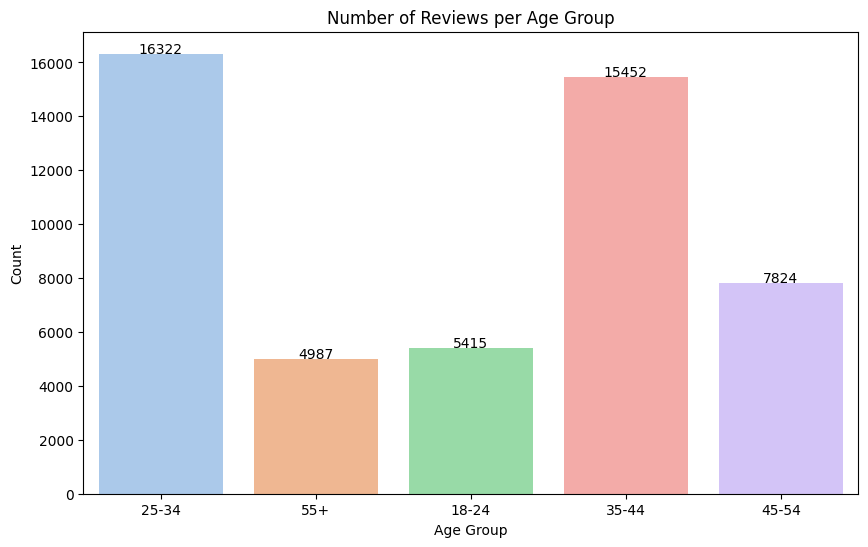

In [7]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df, x='age_group', palette='pastel')
plt.title('Number of Reviews per Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Add counts above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 20,  # adjust +20 for spacing
            f'{int(height)}', ha="center", fontsize=10)

plt.show()

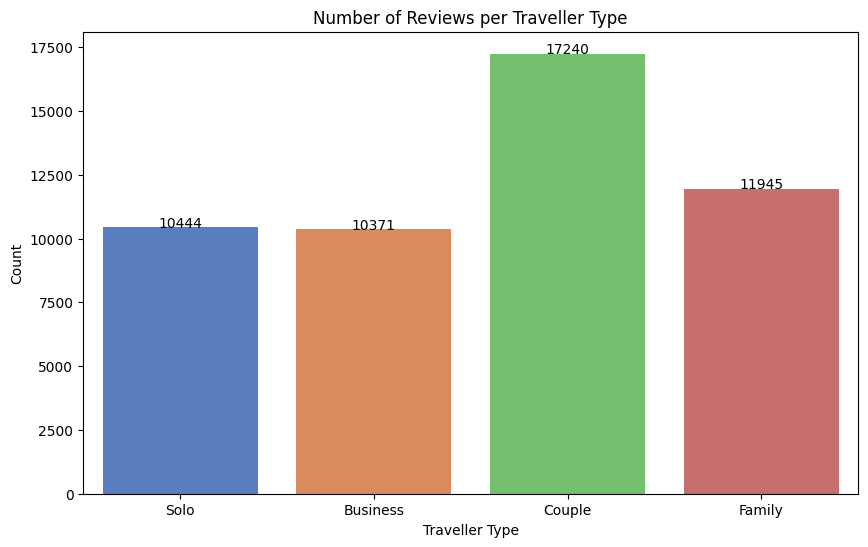

In [8]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df, x='traveller_type', palette='muted')
plt.title('Number of Reviews per Traveller Type')
plt.xlabel('Traveller Type')
plt.ylabel('Count')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 5, str(int(p.get_height())), 
            ha='center', fontsize=10)
plt.show()

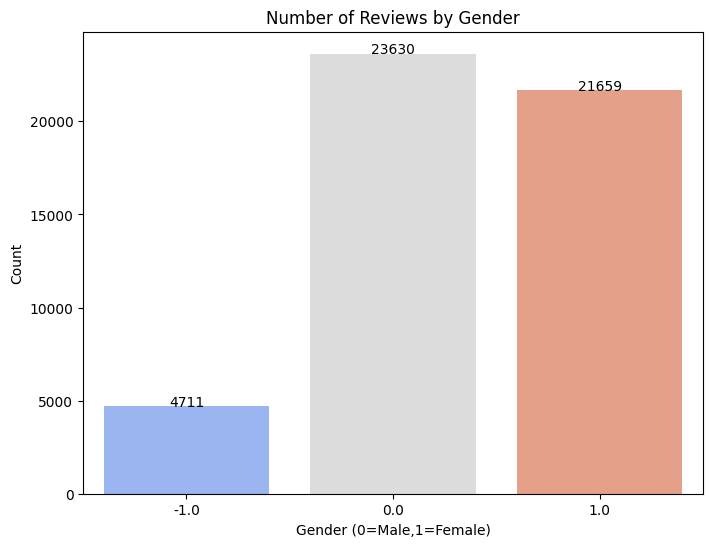

In [9]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='user_gender', palette='coolwarm')
plt.title('Number of Reviews by Gender')
plt.xlabel('Gender (0=Male,1=Female)')
plt.ylabel('Count')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 5, str(int(p.get_height())), 
            ha='center', fontsize=10)
plt.show()

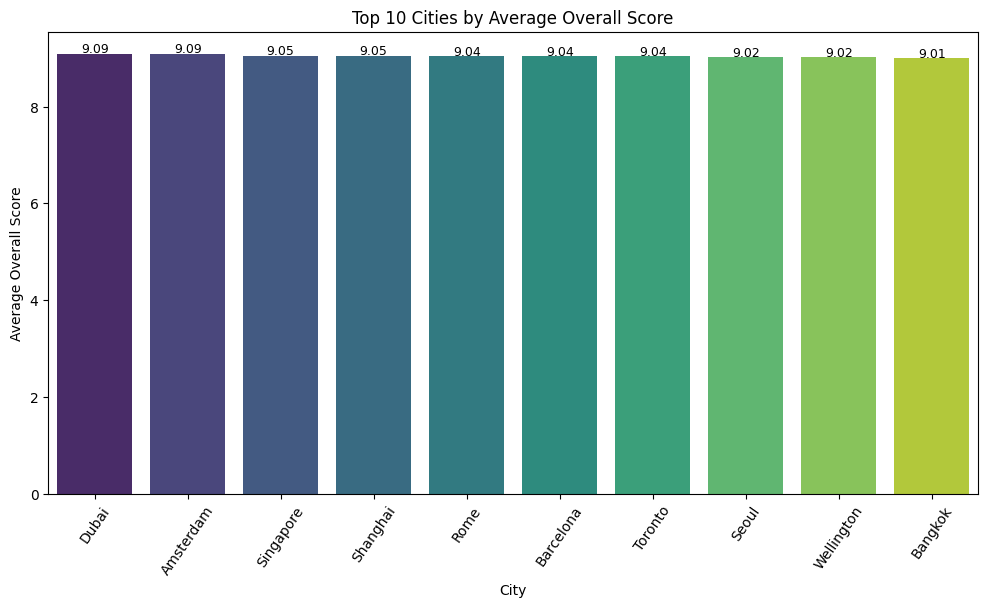

In [10]:
top_cities = df.groupby('city')['score_overall'].mean().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top_cities, x='city', y='score_overall', palette='viridis')
plt.xticks(rotation=55)
plt.title('Top 10 Cities by Average Overall Score')
plt.xlabel('City')
plt.ylabel('Average Overall Score')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.02, f'{p.get_height():.2f}', 
            ha='center', fontsize=9)
plt.show()

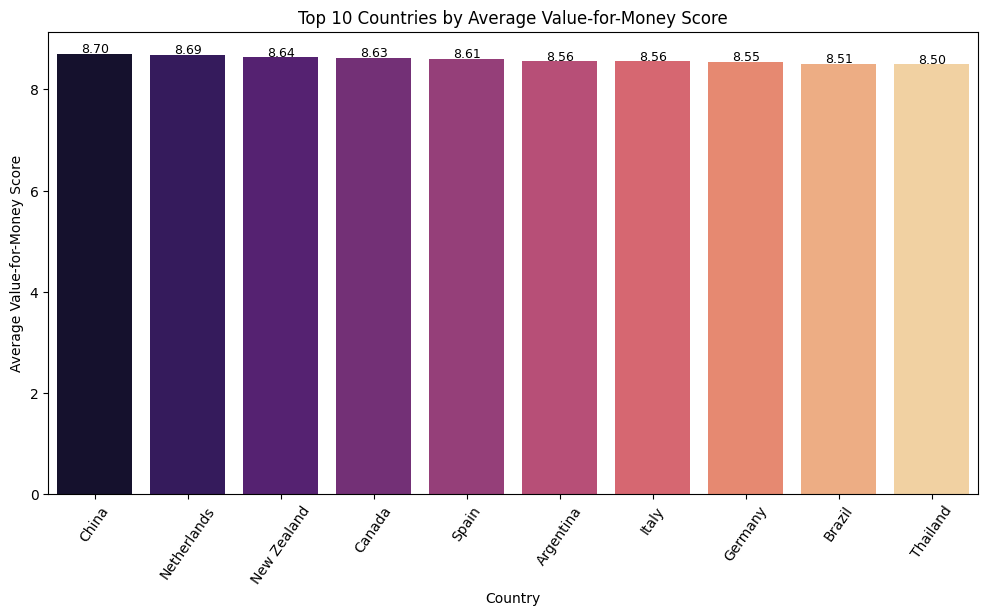

In [11]:
top_countries = df.groupby('hotel_country')['score_value_for_money'].mean().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top_countries, x='hotel_country', y='score_value_for_money', palette='magma')
plt.xticks(rotation=55)
plt.title('Top 10 Countries by Average Value-for-Money Score')
plt.xlabel('Country')
plt.ylabel('Average Value-for-Money Score')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.02, f'{p.get_height():.2f}', 
            ha='center', fontsize=9)
plt.show()

# Data-Engineering Questions

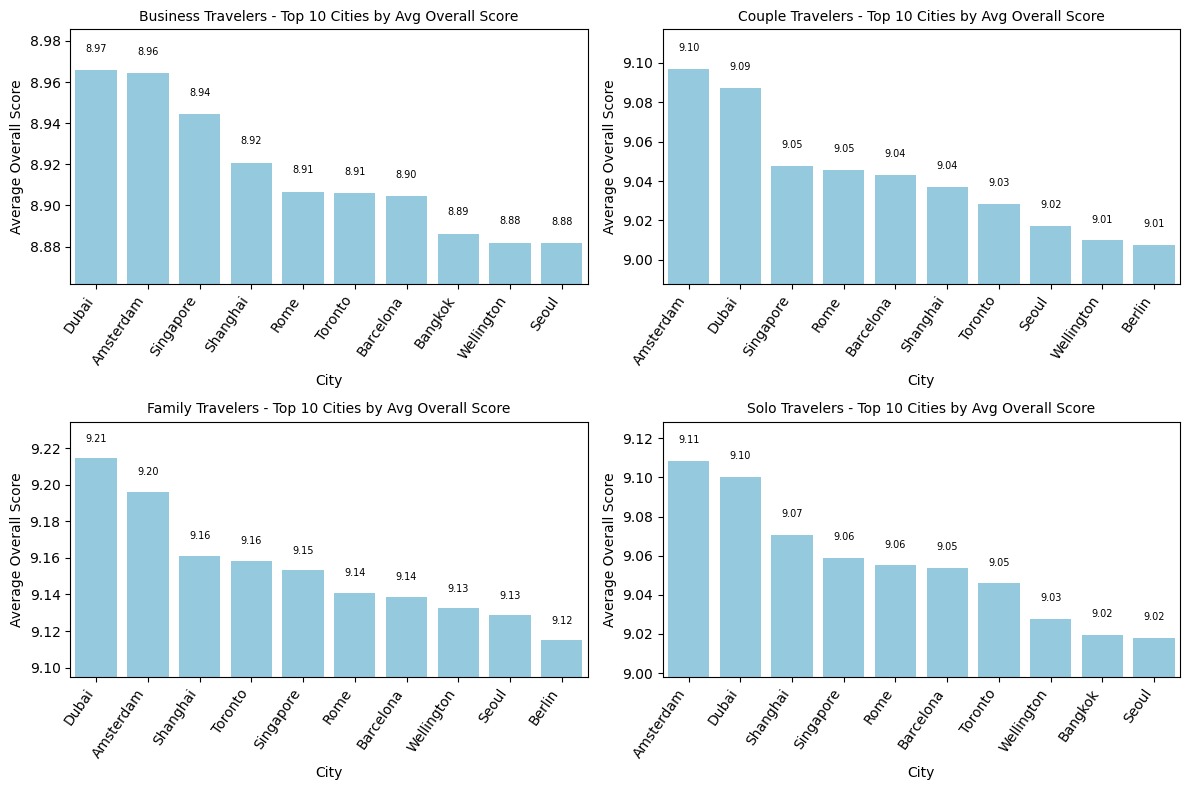

In [12]:
grouped1_df = df.groupby(['traveller_type', 'city'])['score_overall'].mean().reset_index()
n = 10
top_n_cities = (
    grouped1_df
    .sort_values(['traveller_type', 'score_overall'], ascending=[True, False])
    .groupby('traveller_type')
    .head(n)
)
top_n_cities.head(20)
plt.figure(figsize=(12, 8))
traveller_types = top_n_cities['traveller_type'].unique()

for i, ttype in enumerate(traveller_types):
    plt.subplot(2, 2, i + 1)
    subset = (
        top_n_cities[top_n_cities['traveller_type'] == ttype]
        .sort_values('score_overall', ascending=False)
    )
    
    # Plot vertical bar chart for each traveller type
    sns.barplot(data=subset, x='city', y='score_overall', color='skyblue')
    
    # Annotate each bar with its value
    for index, value in enumerate(subset['score_overall']):
        plt.text(index, value + 0.009, f'{value:.2f}', ha='center', fontsize=7)
    
    # Title and axis labels
    plt.title(f'{ttype} Travelers - Top {n} Cities by Avg Overall Score', fontsize=10)
    plt.xlabel('City')
    plt.ylabel('Average Overall Score')
    plt.ylim(subset['score_overall'].min() - 0.02, subset['score_overall'].max() + 0.02)
    plt.xticks(rotation=55, ha='right')

plt.tight_layout()
plt.show()

### Based on the average overall scores from traveler reviews, the best city for each traveler type is:

- **Business Travelers:** **Dubai** (Average Score: 8.97)
- **Couple Travelers:** **Amsterdam** (Average Score: 9.10)
- **Family Travelers:** **Dubai** (Average Score: 9.21)
- **Solo Travelers:** **Amsterdam** (Average Score: 9.11)

These recommendations are based on the top-rated cities according to user reviews for each traveler category.


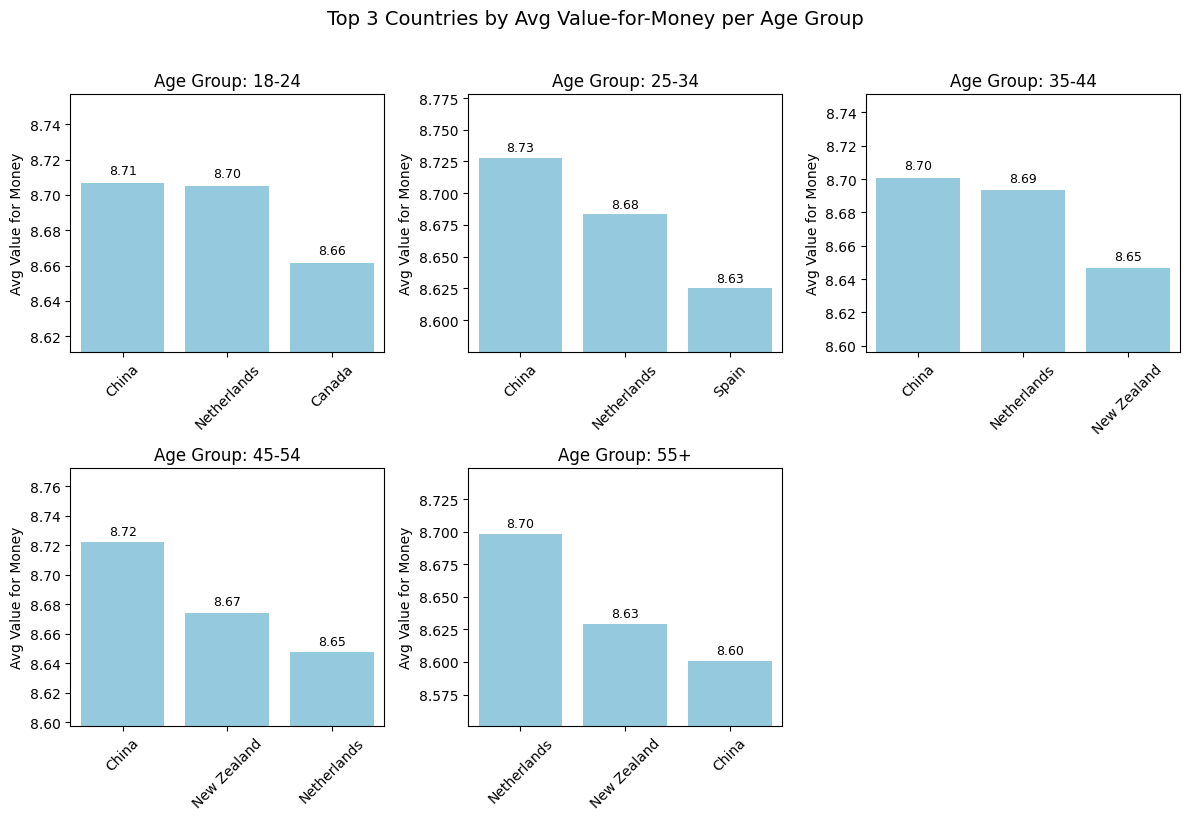

In [13]:
# Group by age_group and hotel_country to get mean value_for_money score
x = 3
grouped_age = (
    df.groupby(['age_group', 'hotel_country'])['score_value_for_money']
      .mean()
      .reset_index()
      .sort_values(['age_group', 'score_value_for_money'], ascending=[True, False])
      .groupby('age_group')
      .head(x)
      .reset_index(drop=True)
)

# Plot top 3 countries per age group
plt.figure(figsize=(12, 8))
age_groups = grouped_age['age_group'].unique()

ncols = 3
nrows = (len(age_groups) + ncols - 1) // ncols

for i, ag in enumerate(age_groups):
    ax = plt.subplot(nrows, ncols, i + 1)
    subset = grouped_age[grouped_age['age_group'] == ag].sort_values('score_value_for_money', ascending=False)
    sns.barplot(data=subset, x='hotel_country', y='score_value_for_money', ax=ax, color='skyblue')
    for idx, val in enumerate(subset['score_value_for_money']):
        ax.text(idx, val + 0.005, f'{val:.2f}', ha='center', fontsize=9)
    ax.set_title(f'Age Group: {ag}')
    ax.set_xlabel('')
    ax.set_ylabel('Avg Value for Money')
    ax.set_ylim(subset['score_value_for_money'].min() - 0.05, subset['score_value_for_money'].max() + 0.05)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Top 3 Countries by Avg Value-for-Money per Age Group', fontsize=14, y=1.02)
plt.show()


### Top 3 Countries by Avg Value-for-Money per Traveler Age Group

- **Age Group 18-24:**  
  1. China – 8.71  
  2. Netherlands – 8.70  
  3. Canada – 8.66  

- **Age Group 25-34:**  
  1. China – 8.73  
  2. Netherlands – 8.68  
  3. Spain – 8.63  

- **Age Group 35-44:**  
  1. China – 8.70  
  2. Netherlands – 8.69  
  3. New Zealand – 8.65  

- **Age Group 45-54:**  
  1. China – 8.72  
  2. New Zealand – 8.67  
  3. Netherlands – 8.65  

- **Age Group 55+:**  
  1. Netherlands – 8.70  
  2. New Zealand – 8.63  
  3. China – 8.60  


# Predictive Modeling Task

In [14]:
# one-hot encode categorical columns
categorical_cols = ['traveller_type', 'age_group', 'city']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=np.uint8)

In [15]:
X = df[['star_rating',
 'cleanliness_base', 'comfort_base', 'facilities_base',
 'location_base', 'staff_base', 'value_for_money_base',
 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities',
 'score_location', 'score_staff', 'score_value_for_money', 'user_gender',
 'traveller_type_Couple', 'traveller_type_Family', 'traveller_type_Solo',
 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55+',
 'city_Bangkok', 'city_Barcelona', 'city_Berlin', 'city_Buenos Aires',
 'city_Cairo', 'city_Cape Town', 'city_Dubai', 'city_Istanbul', 'city_Lagos',
 'city_London', 'city_Mexico City', 'city_Moscow', 'city_Mumbai', 'city_New York',
 'city_Paris', 'city_Rio de Janeiro', 'city_Rome', 'city_Seoul', 'city_Shanghai',
 'city_Singapore', 'city_Sydney', 'city_Tokyo', 'city_Toronto', 'city_Wellington']]

y = df['country_group']

In [16]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_categorical = to_categorical(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical,
test_size=0.2, random_state=42)
print("\nLabel-encoded (numeric) y:")
print(y_encoded)

print("\nOne-hot encoded y (matrix):")
print(y_categorical)


Label-encoded (numeric) y:
[ 6 10  6 ... 10 10 10]

One-hot encoded y (matrix):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [17]:
model = Sequential([Input(shape=(X_train.shape[1],)),
layers.Dense(128, activation='relu'),
layers.Dense(64, activation='relu'),
layers.Dense(y_train.shape[1], activation='softmax') 
])
model.summary()

2025-10-22 01:04:38.767621: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,987 (58.54 KB)

 Trainable params: 14,987 (58.54 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy',
Precision(name='precision'),
Recall(name='recall')])


In [19]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3221 - loss: 2.0290 - precision: 0.3894 - recall: 0.0201 - val_accuracy: 0.3309 - val_loss: 1.9877 - val_precision: 0.4050 - val_recall: 0.0264
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3397 - loss: 1.9675 - precision: 0.3605 - recall: 0.0042 - val_accuracy: 0.3309 - val_loss: 1.9674 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3392 - loss: 1.9677 - precision: 0.4070 - recall: 5.5664e-04 - val_accuracy: 0.3309 - val_loss: 1.9596 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3368 - loss: 1.9548 - precision: 0.0220 - recall: 3.4925e-06 - val_accuracy: 0.3309 - val_loss: 1.9561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3380 - loss: 1.9663 - precision: 0.3305 - recall: 5.

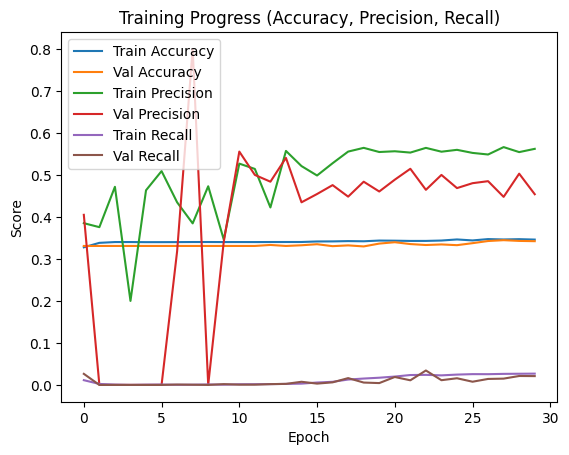

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Progress (Accuracy, Precision, Recall)')
plt.legend()
plt.show()


In [21]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test,
y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


Test Loss: 1.8786367177963257
Test Accuracy: 0.34279999136924744
Test Precision: 0.5032397508621216
Test Recall: 0.02329999953508377


# Model Explainability

In [22]:
import shap
shap.initjs()

import lime
import lime.lime_tabular

In [23]:
background = shap.sample(X_train, 100, random_state=42)
explainer = shap.Explainer(model, background)
shap_values = explainer(X_test[0:100])

PermutationExplainer explainer: 101it [00:11,  1.76it/s]



# Absolute Mean SHAP
This plot shows the contribution of each feature globally and ranks them

Classes: ['Africa' 'East_Asia' 'Eastern_Europe' 'Middle_East' 'North_America'
 'North_America_Mexico' 'Oceania' 'South_America' 'South_Asia'
 'Southeast_Asia' 'Western_Europe']


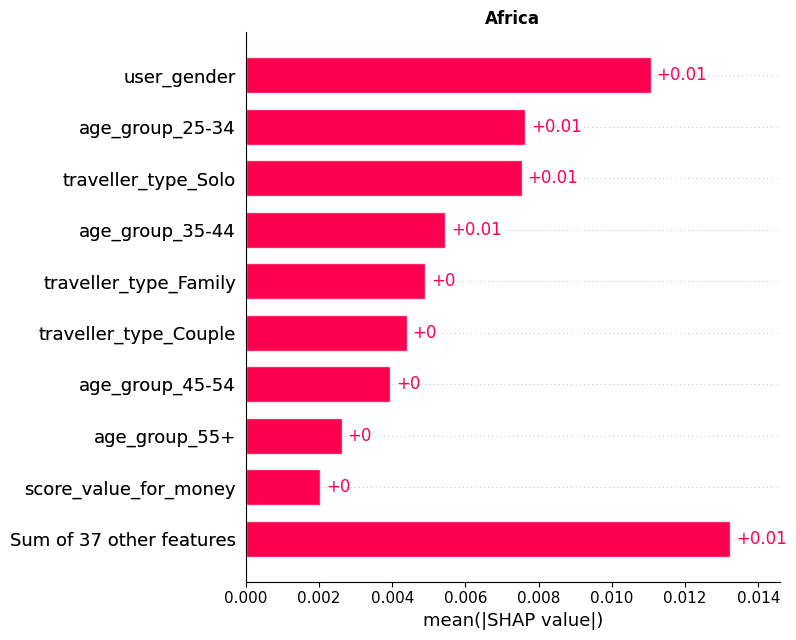

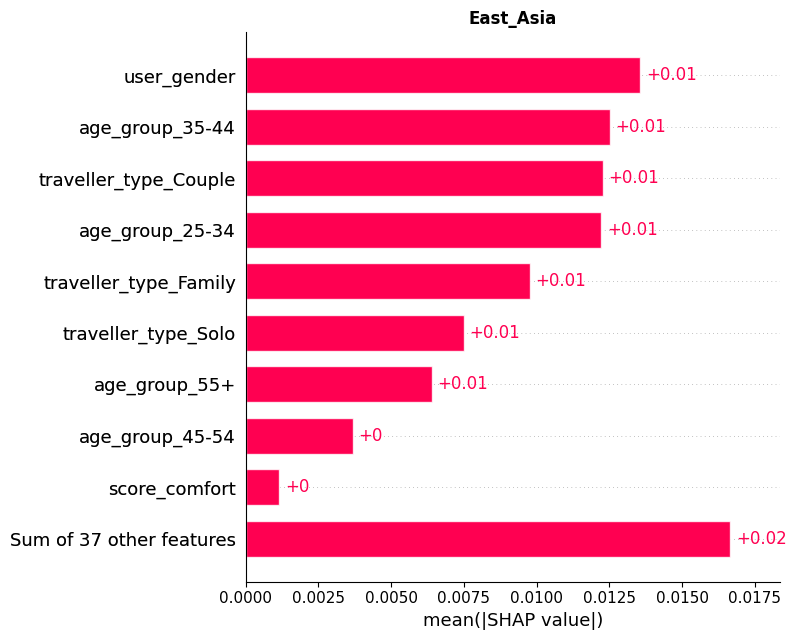

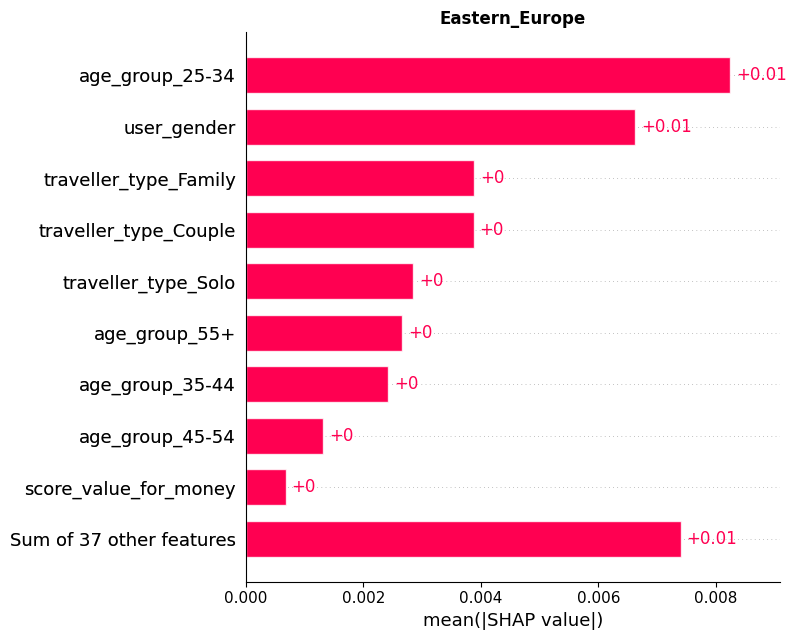

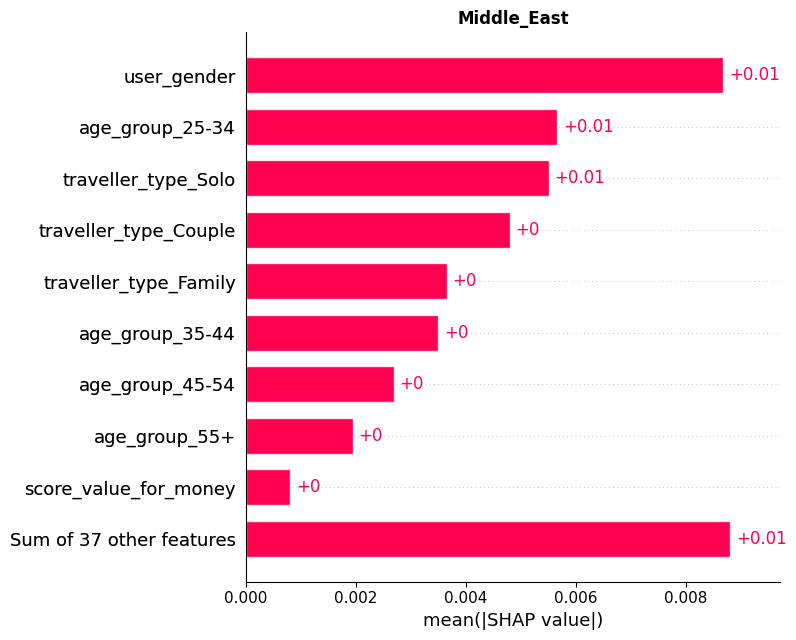

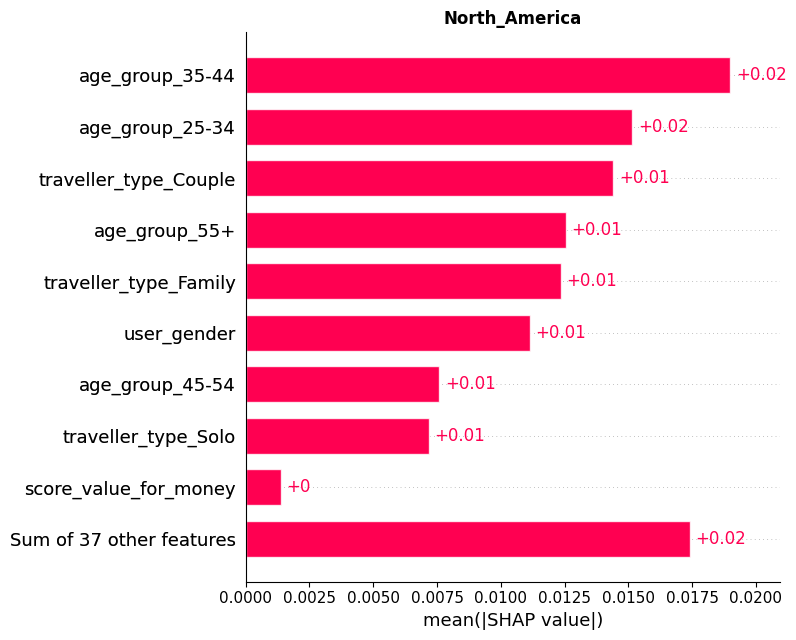

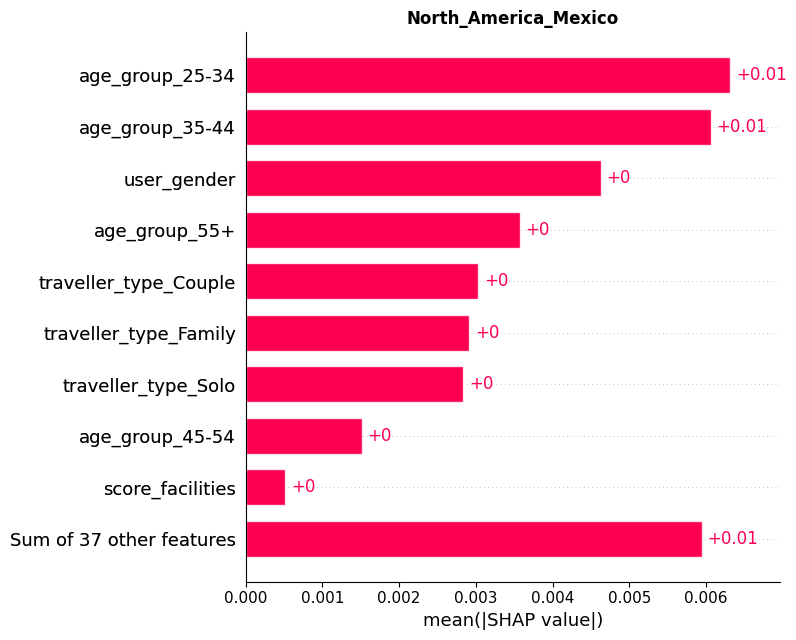

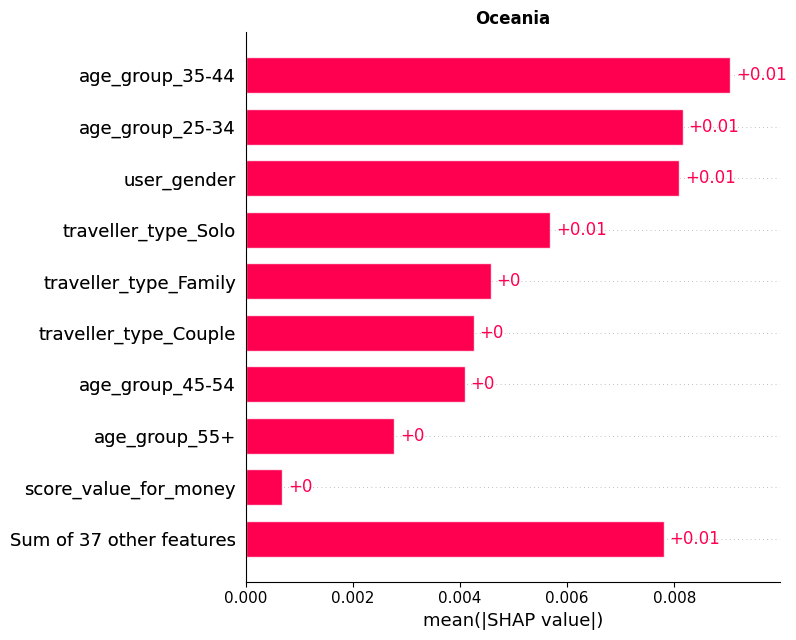

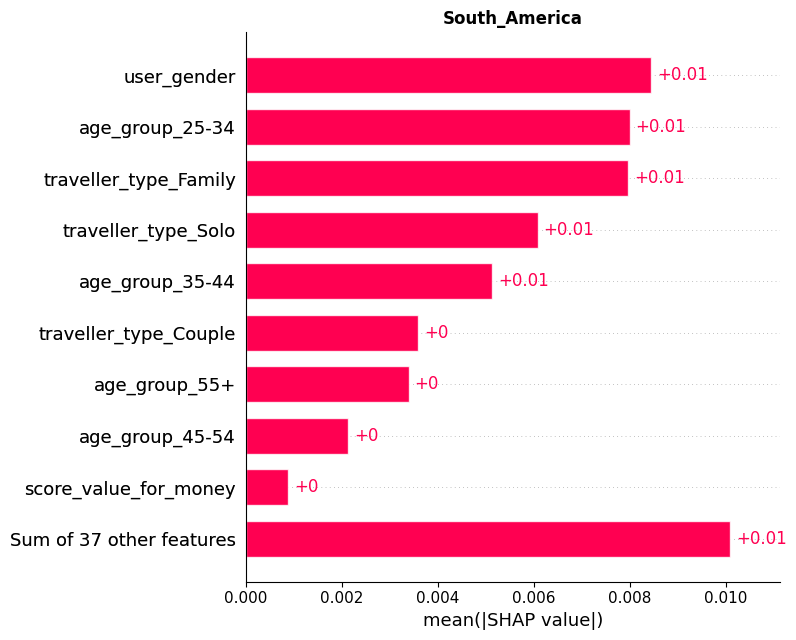

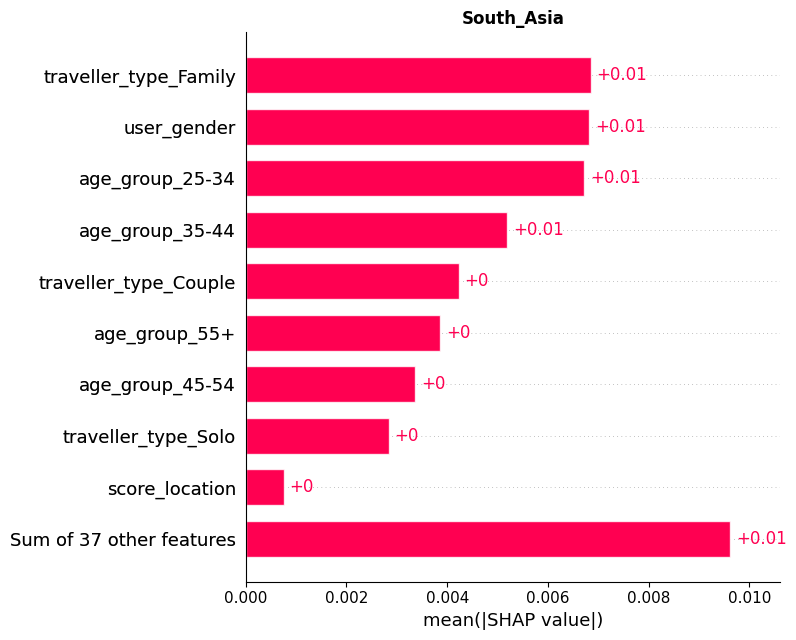

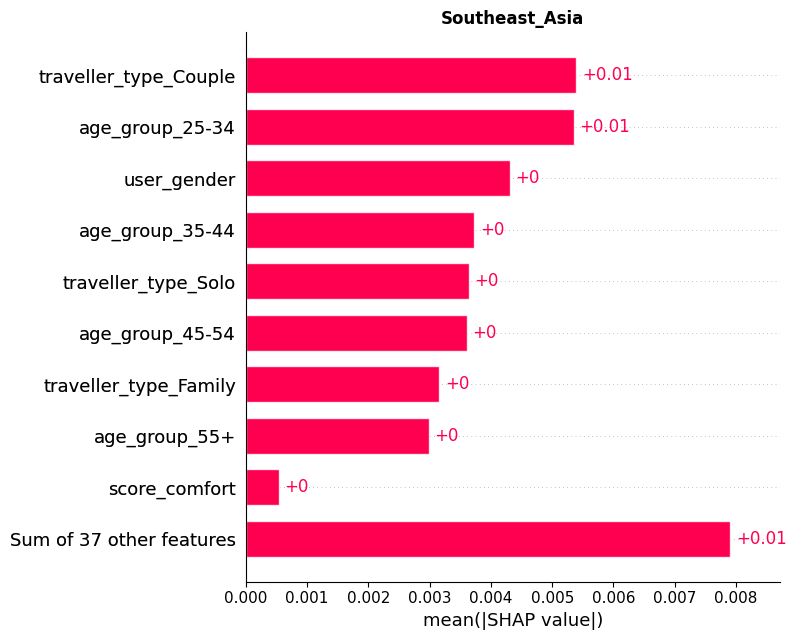

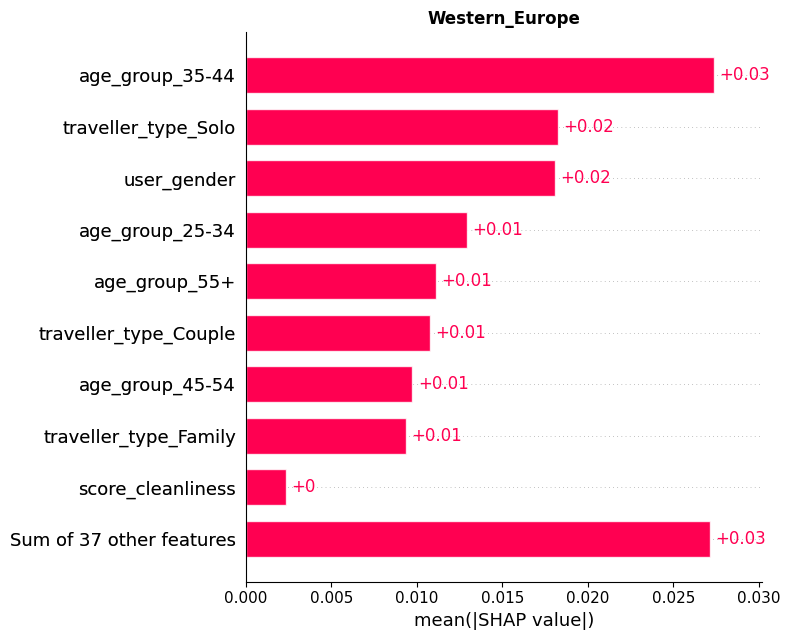

In [24]:

class_names = label_encoder.classes_
print("Classes:", class_names)

for class_idx in range(11):
    # Extract SHAP values for this specific class
    shap_values_class = shap_values[:, :, class_idx]
    
    # Create bar plot for this class
    fig, ax = plt.subplots(figsize=(16, 6))  # new figure and axis
    shap.plots.bar(shap_values_class, show=False)
    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Waterfall Plot
This plot shows the contribution of each feature, moving it from the baseline value, to the prediction value

# Force Plot
This is a similar perspective, in a different format
from IPython.display import display

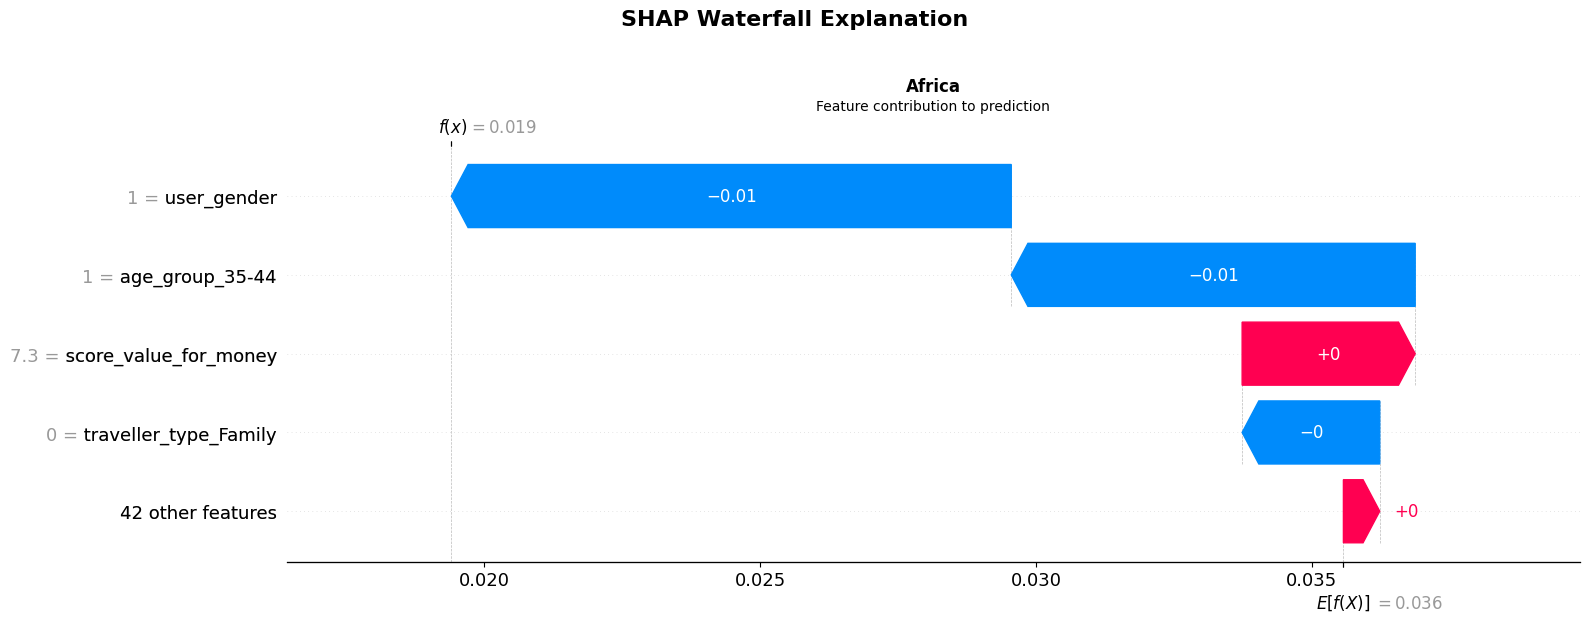

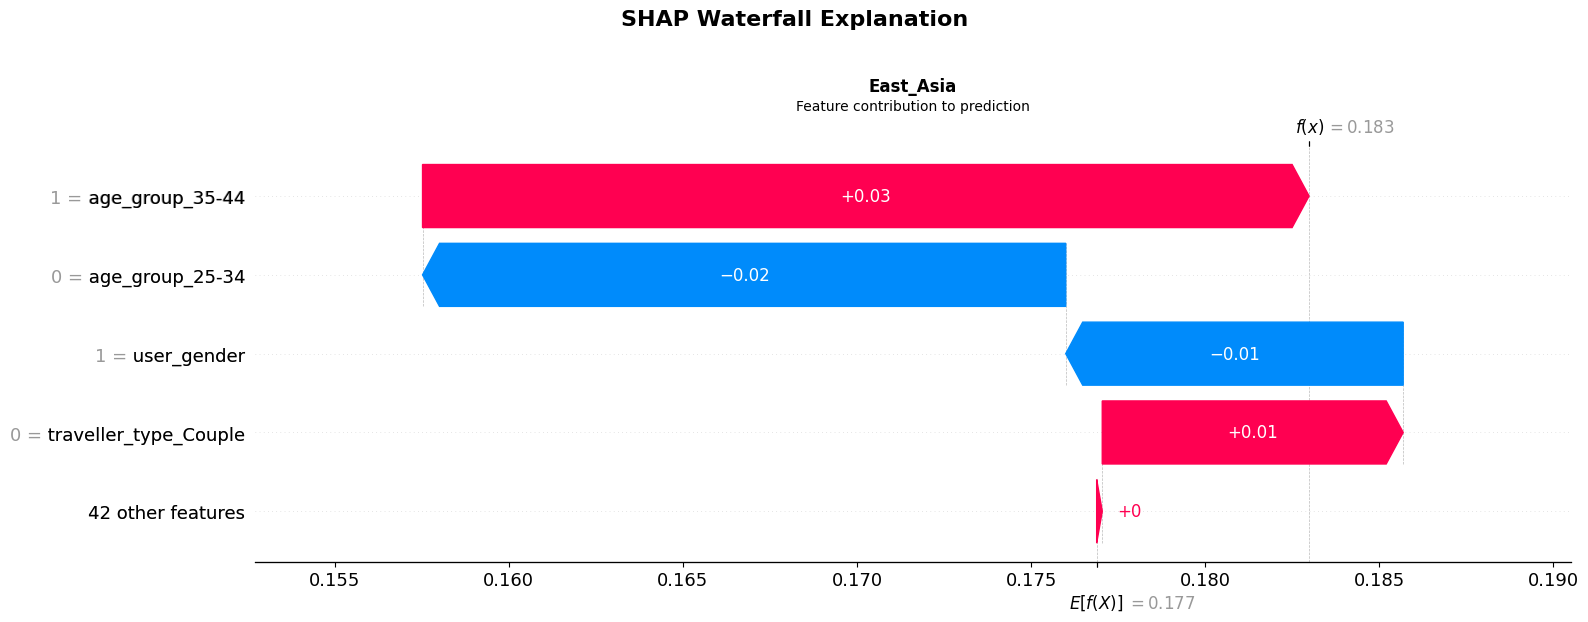

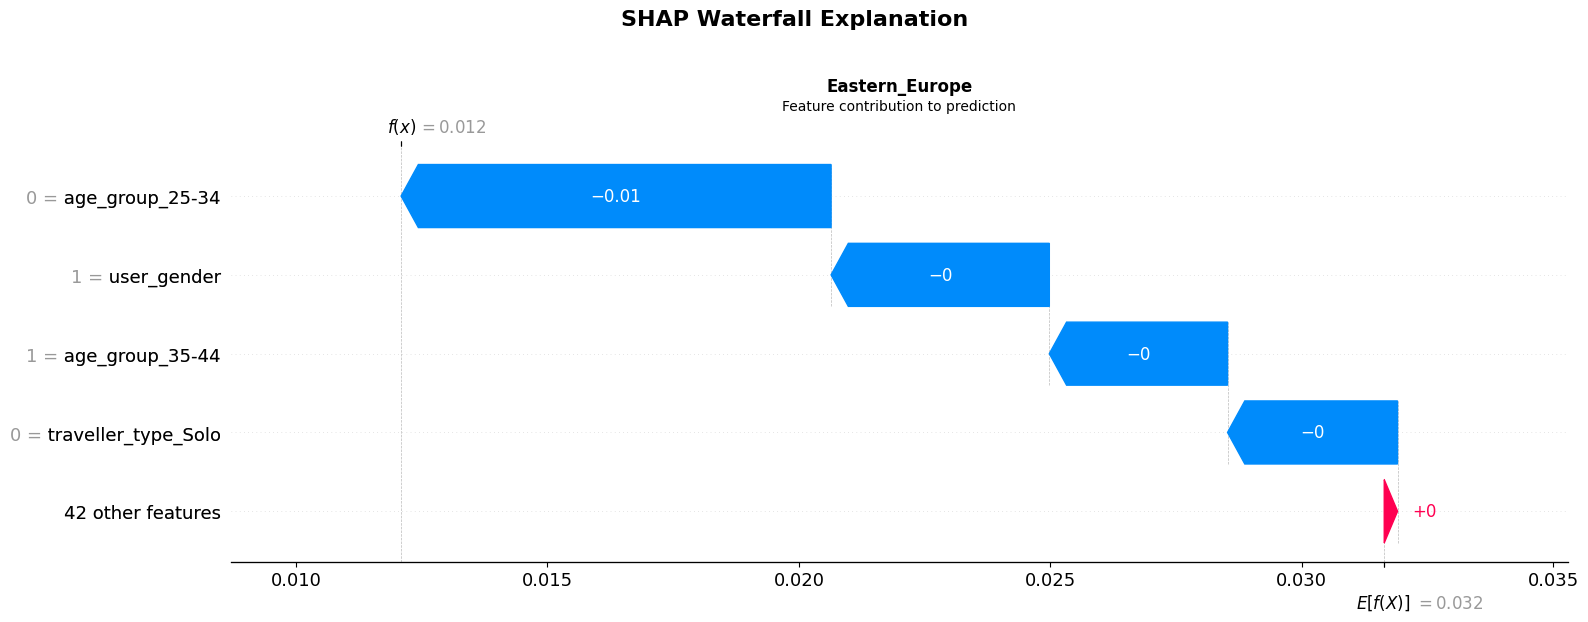

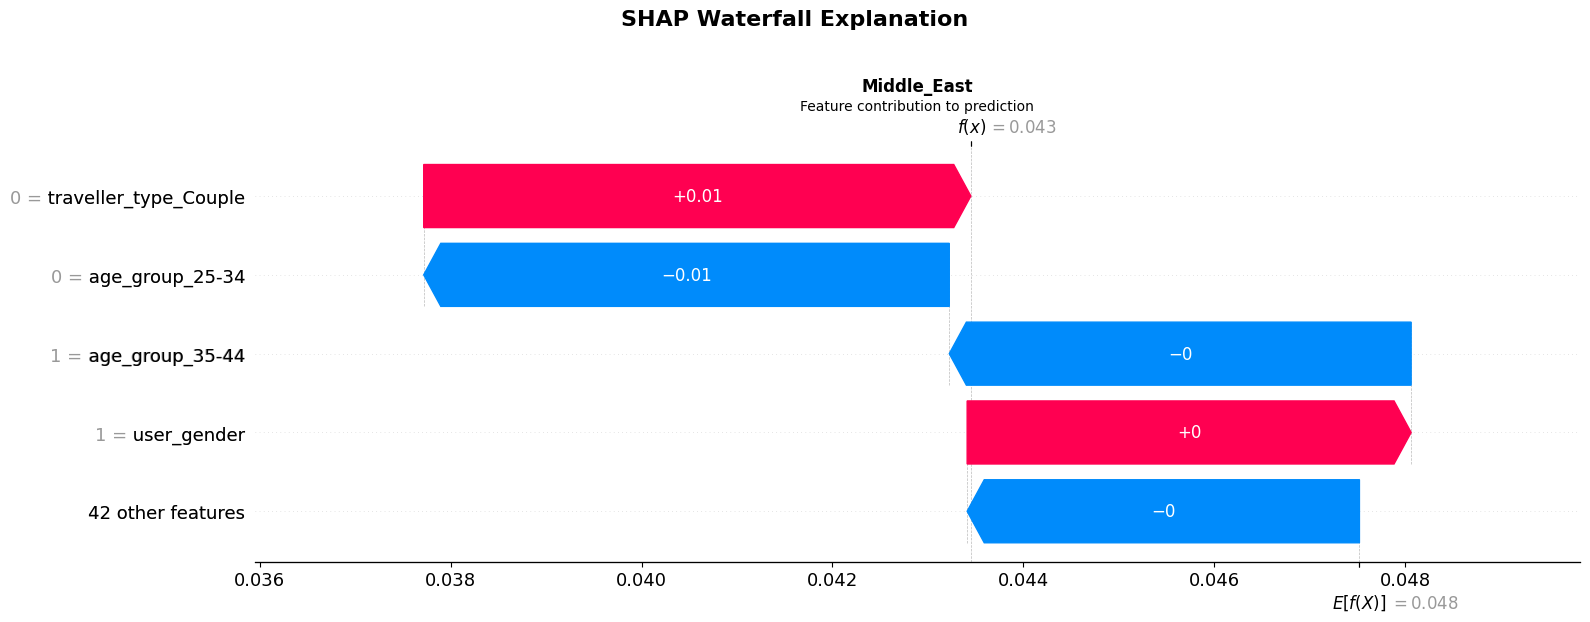

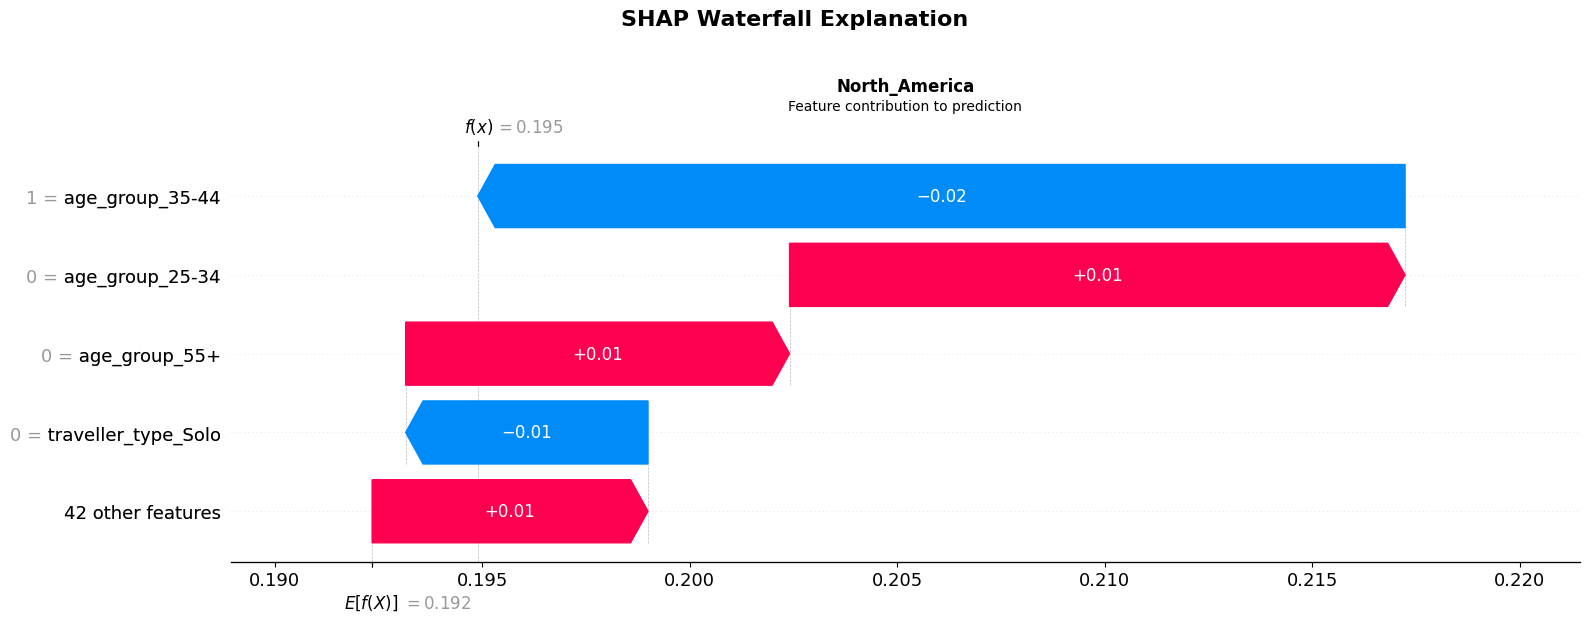

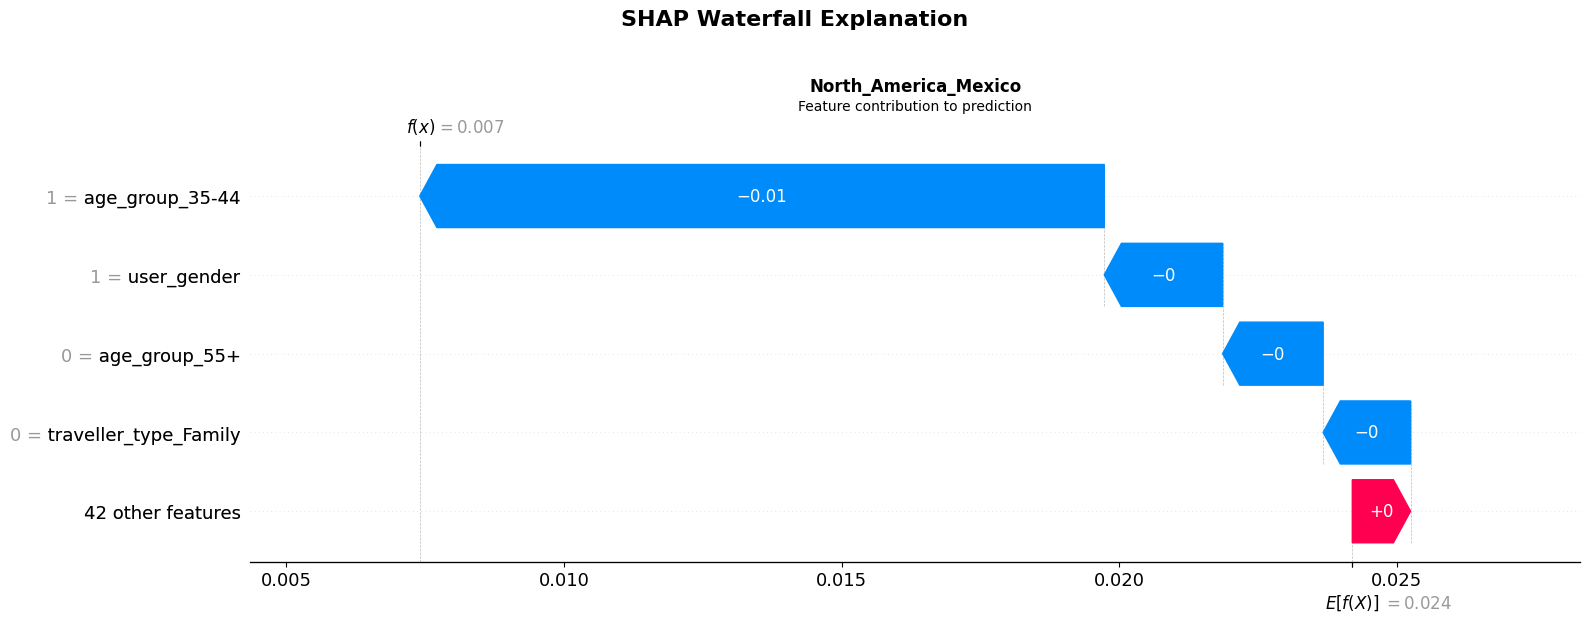

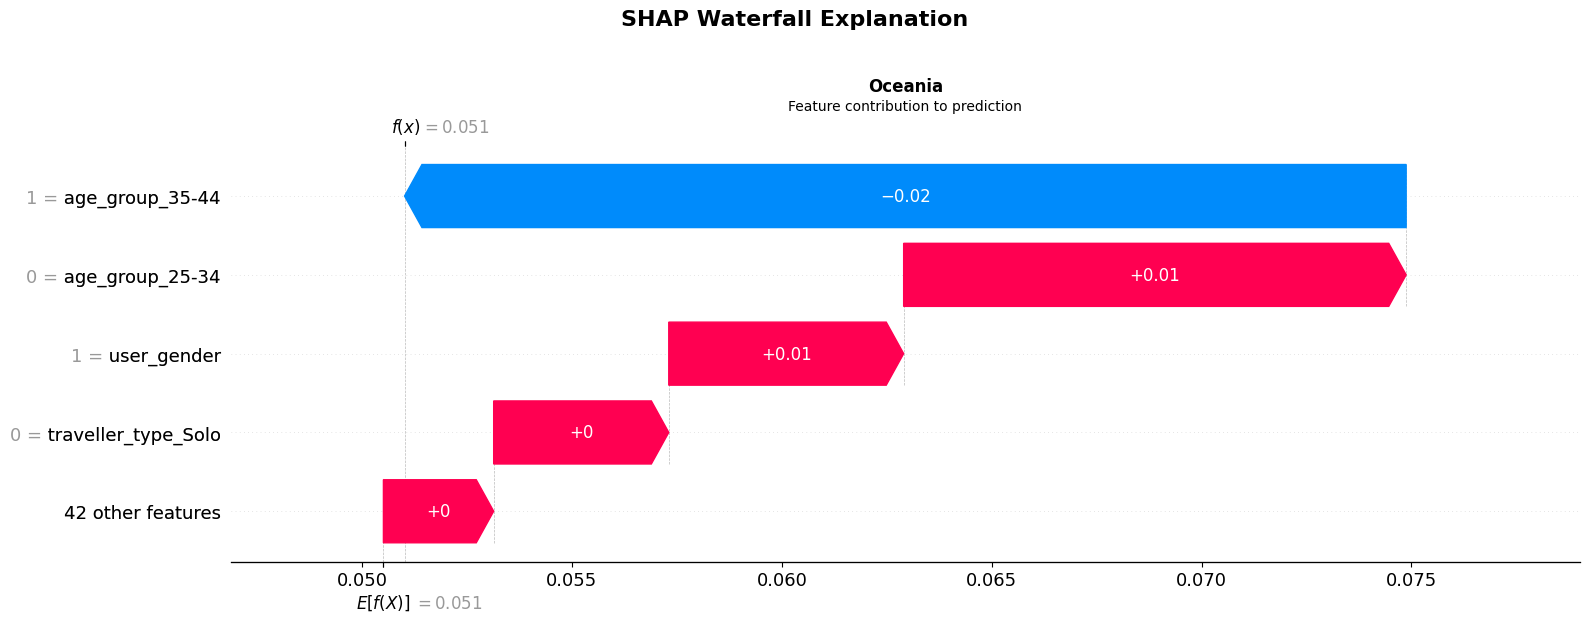

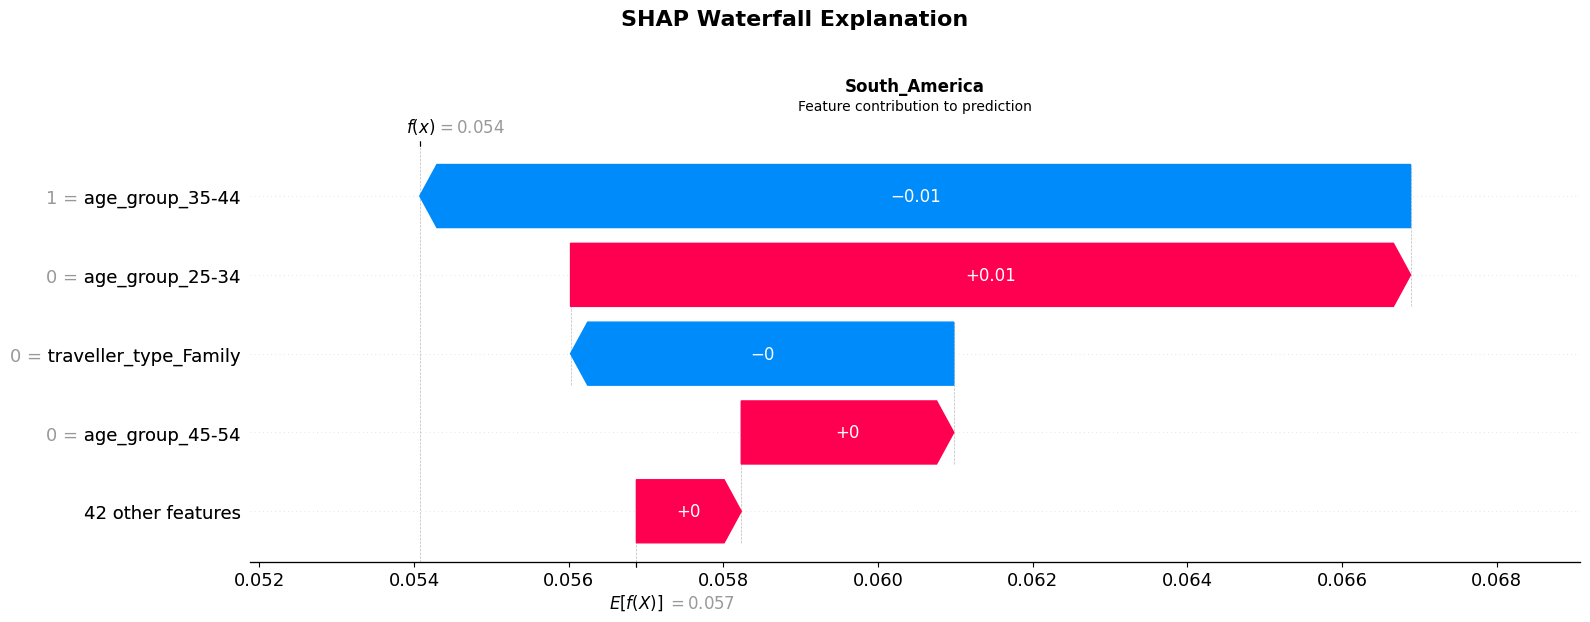

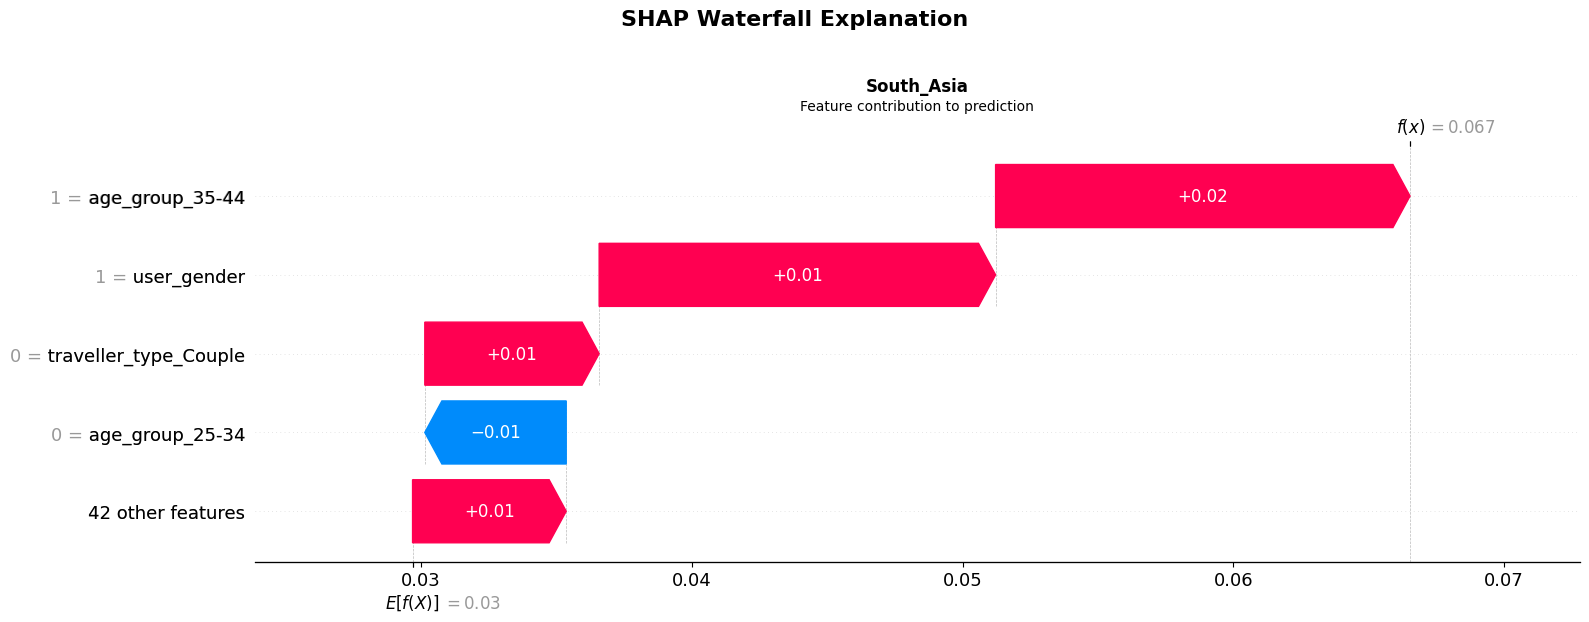

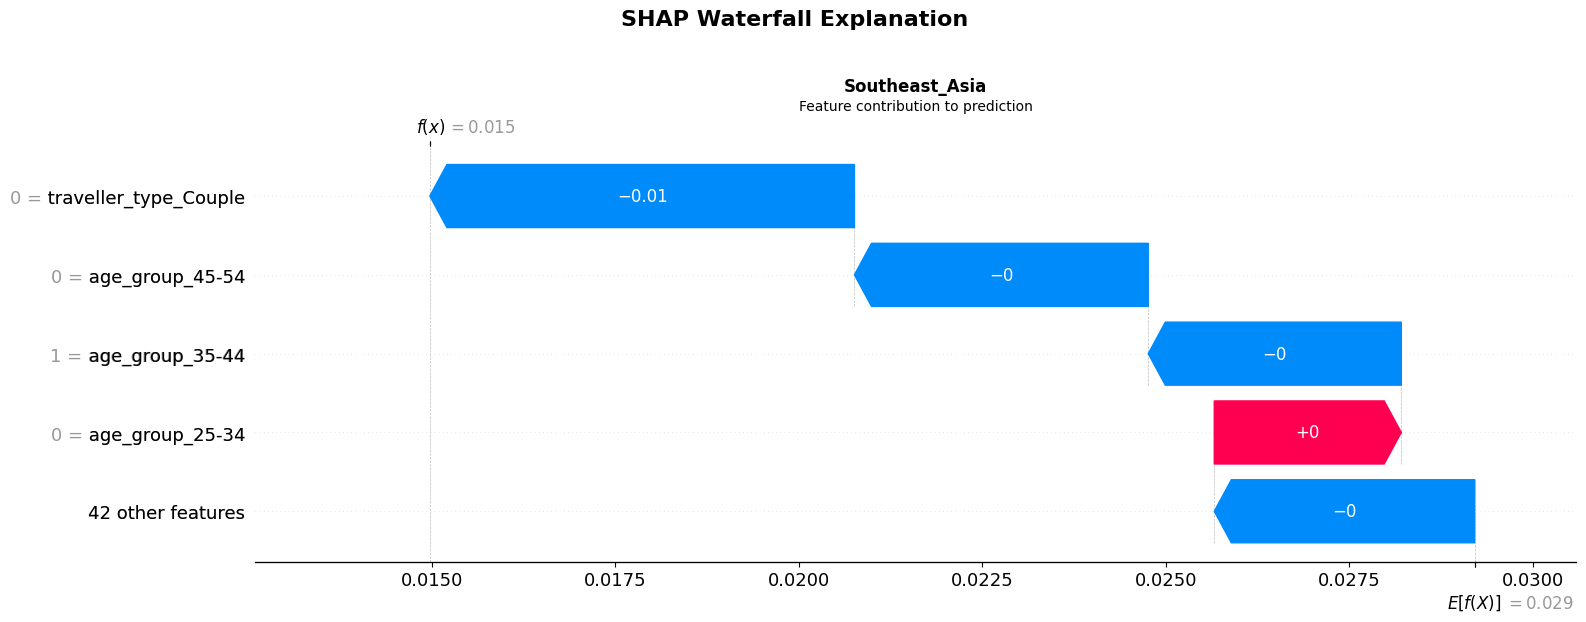

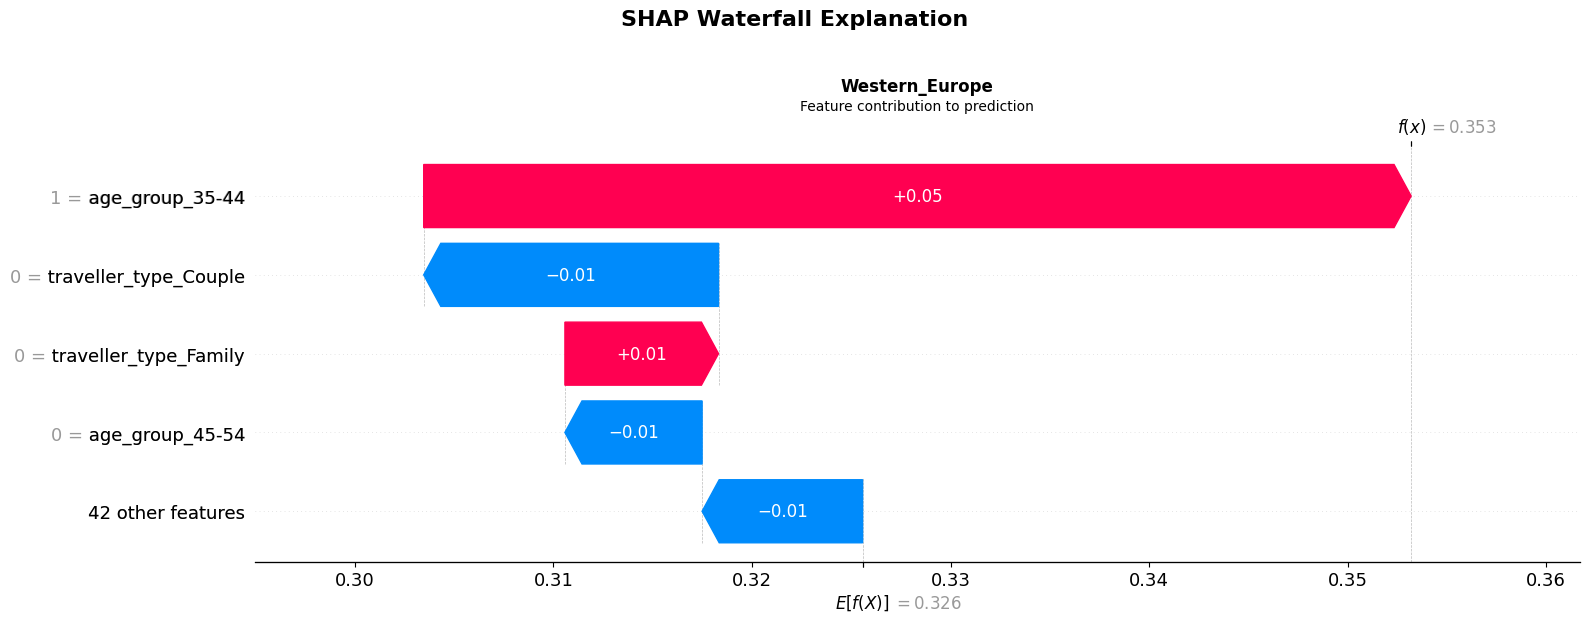

In [25]:

observation = 0

# plt.rcParams['figure.figsize'] = (12, 6)  # default width/height for new figures


for class_idx in range(11):
    # Extract SHAP values for this specific class and observation
    shap_values_class_observation = shap_values[observation, :, class_idx]

    shap.plots.waterfall(shap_values_class_observation, max_display=5, show=False)

    fig = plt.gcf()   # get the current figure
    ax = plt.gca()    # get the current axes

    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    ax.set_xlabel("Feature contribution to prediction")
    fig.suptitle("SHAP Waterfall Explanation", fontsize=16, fontweight="bold", y=1.03)
    plt.gcf().set_size_inches(16, 6)

    plt.tight_layout()
    plt.show()

    display(shap.plots.force(shap_values_class_observation))